In [1]:
import torch
import json
import textwrap

#repo = "models/kosmos-2.5"
repo = "models/kosmos-2-patch14-224"

# Open and read the JSON file with
json_path = repo + "/config.json"
with open(json_path, 'r') as file:
    config_data = json.load(file)

if repo == "models/kosmos-2.5":
    from transformers import AutoProcessor, AutoConfig, AutoModelForVision2Seq
    
if repo == "models/kosmos-2-patch14-224":
    from transformers import AutoProcessor, AutoModelForImageTextToText

import fitz  # PyMuPDF is imported as fitz
from PIL import Image

/home/rglinux/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

pdf parser
Description
A open source parser for pdfs:
pdf2image
image2text

{'width': 595.3200073242188, 'height': 841.9200439453125, 'blocks': [{'number': 0, 'type': 0, 'bbox': (56.76000213623047, 57.107601165771484, 201.7105712890625, 97.9920883178711), 'lines': [{'spans': [{'size': 12.000450134277344, 'flags': 4, 'font': 'CIDFont+F1', 'color': -16777216, 'ascender': 0.890999972820282, 'descender': -0.2160000056028366, 'text': 'pdf parser', 'origin': (56.76000213623047, 67.80000305175781), 'bbox': (56.76000213623047, 57.107601165771484, 105.03617095947266, 70.39209747314453)}], 'wmode': 0, 'dir': (1.0, 0.0), 'bbox': (56.76000213623047, 57.107601165771484, 105.03617095947266, 70.39209747314453)}, {'spans': [{'size': 12.000450134277344, 'flags': 4, 'font': 'CIDFont+F1', 'color': -16777216, 'ascender': 0.890999972820282, 'descender': -0.2160000056028366, 'text': 'Description', 'origin': (56.76000213623047, 81.60000610351562), 'bbox': (56.76000213623047, 70.90760803222656, 112.7123260498

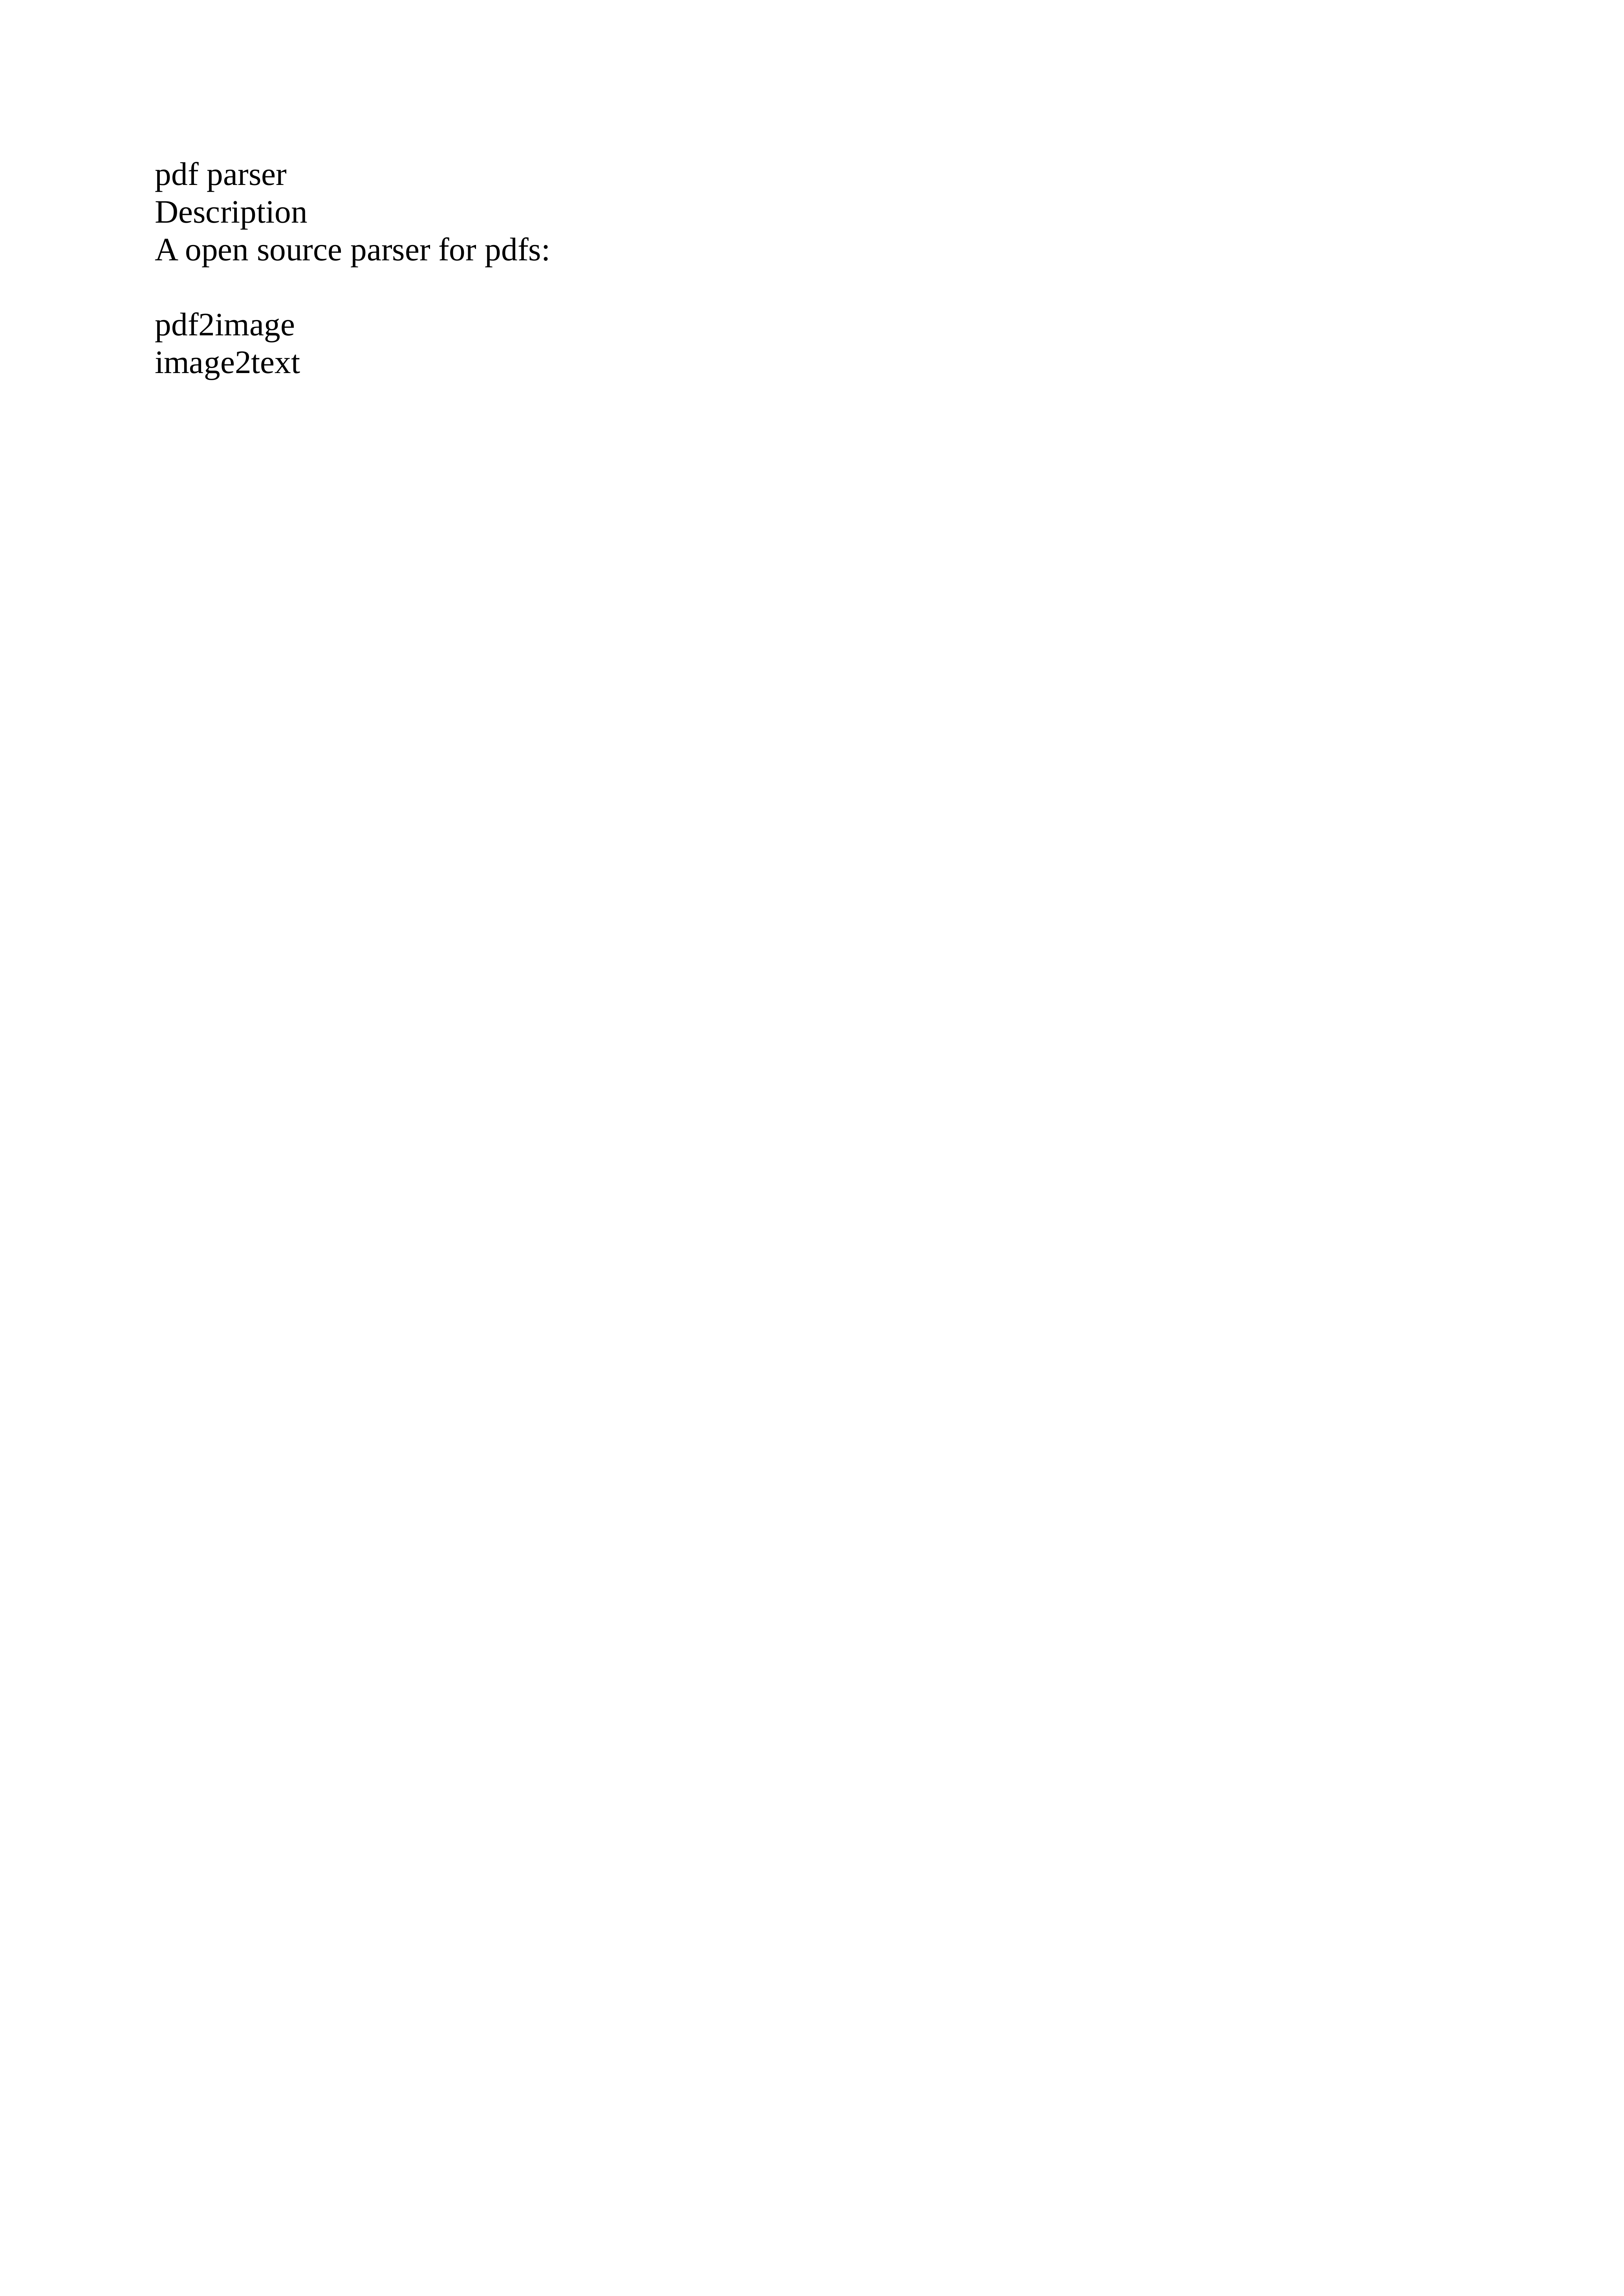

In [3]:
path = "/home/rglinux/.git/pdf_parser/data/Readme.pdf"
doc = fitz.open(path)
page = doc.load_page(0)

print(page.get_text("text"))
print(page.get_text("dict"))
print(page.get_text("html"))
print(page.get_fonts())


pixmap = page.get_pixmap(dpi=500)

image = Image.frombytes("RGB", [pixmap.width, pixmap.height], pixmap.samples)
image

In [4]:
device = "cuda"
dtype = torch.float16

if repo == "models/kosmos-2.5":
    config = AutoConfig.from_pretrained(repo)
    # Load model directly
    model = AutoModelForVision2Seq.from_pretrained(
        repo, device_map=device, torch_dtype=dtype, config=config
    )
    processor = AutoProcessor.from_pretrained(repo)
if repo == "models/kosmos-2-patch14-224":
    # Load model directly
    processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
    model = AutoModelForImageTextToText.from_pretrained("microsoft/kosmos-2-patch14-224")
    
# Move model to the correct device and dtype
model.to(device)
model = model.half() if dtype == torch.float16 else model.float()

In [5]:
inputs = processor(
    images=image,
    text="Extract the exact text from the image to markdown format <md>",
    return_tensor="pt"
)

# Safely retrieve the height and width if they exist
height = inputs.pop("height", None)
width = inputs.pop("width", None)

if height is None or width is None:
    print("Height or width not found in inputs.")
else:
    print(f"Height: {height}, Width: {width}")

# Safely handle 'flattened_patches'
if "flattened_patches" in inputs:
    inputs["flattened_patches"] = inputs["flattened_patches"].to(dtype)
else: 
    print("'flattened_patches' key not found in inputs.")

import numpy as np

# Handle lists, numpy arrays, and simple types separately
def convert_to_tensor(value):
    if isinstance(value, np.ndarray):
        return torch.tensor(value, dtype=dtype).to(device)
    elif isinstance(value, list):
        return torch.stack([convert_to_tensor(item) if isinstance(item, (np.ndarray, int, float)) else item.to(device) for item in value])
        #return [convert_to_tensor(item) for item in value]
    elif isinstance(value, (int, float)):
        return torch.tensor(value, dtype=dtype).to(device)
    elif value is not None:
        return value.to(device)
    else:
        return None
    
inputs = {k: convert_to_tensor(v) for k, v in inputs.items()}

# Ensure input_ids and attention_mask are in the correct dtype
if "input_ids" in inputs:
    inputs["input_ids"] = inputs["input_ids"].to(torch.long)
if "attention_mask" in inputs:
    inputs["attention_mask"] = inputs["attention_mask"].to(torch.long)
if "image_embeds_position_mask" in inputs:
    inputs["image_embeds_position_mask"] = inputs["image_embeds_position_mask"].to(torch.long)

# Check and fix batch size consistency
batch_size = inputs["pixel_values"].shape[0]
for key, tensor in inputs.items(): 
    if tensor is not None and tensor.shape[0] != batch_size:
        # Add a new dimension and repeat to match the batch size if needed
        if tensor.dim() == 1:
            tensor = tensor.unsqueeze(0).repeat(batch_size, 1)
        elif tensor.dim() == 2:
            tensor = tensor.unsqueeze(0).repeat(batch_size, 1, 1)
        else:
            tensor = tensor.unsqueeze(0).repeat(batch_size, *[1]*(tensor.dim()-1))
        inputs[key] = tensor

# Check shapes and types
for key, tensor in inputs.items():
    if tensor is not None:
        print(f"Key: {key}, Shape: {tensor.shape}, Type: {tensor.dtype}")

Keyword argument `return_tensor` is not a valid argument for this processor and will be ignored.


Height or width not found in inputs.
'flattened_patches' key not found in inputs.
Key: pixel_values, Shape: torch.Size([1, 3, 224, 224]), Type: torch.float16
Key: input_ids, Shape: torch.Size([1, 82]), Type: torch.int64
Key: attention_mask, Shape: torch.Size([1, 82]), Type: torch.int64
Key: image_embeds_position_mask, Shape: torch.Size([1, 82]), Type: torch.int64


In [6]:
# Generate IDs
generated_ids = model.generate(
    **inputs,
    max_new_tokens=4096,
    repetition_penalty=1.05
)

In [7]:
generated_ids

tensor([[    0, 64000,     4,     5,     6,     7,     8,     9,    10,    11,
            12,    13,    14,    15,    16,    17,    18,    19,    20,    21,
            22,    23,    24,    25,    26,    27,    28,    29,    30,    31,
            32,    33,    34,    35,    36,    37,    38,    39,    40,    41,
            42,    43,    44,    45,    46,    47,    48,    49,    50,    51,
            52,    53,    54,    55,    56,    57,    58,    59,    60,    61,
            62,    63,    64,    65,    66,    67, 64000, 52800,     5,  3762,
          2124,    31,     5,  1648,     7,  2338,  3430,  4904,  8000,    78,
           109,  6784, 12202,    11, 20091,   233,  2294,     2]],
       device='cuda:0')

In [8]:
generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)

print("\n".join(textwrap.wrap(generated_text[0], width=80)))

⟨. the, to and of as in I that' for is was- on’ it with The as at bet he have
from by are " you his “ this said not has an ( but had we her they will my or
were their): up about out who one all been she can more would It⟨ 59% the exact
wear from the image to markdown winnersNewsmd louisiana state university
